### Imports

In [100]:
import pandas as pd
import numpy as np
from math import fabs
from sklearn.metrics import r2_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import neighbors, tree, svm
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error    
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

### Loading and Cleaning dataset

In [2]:
df = pd.read_csv("../Data/selected.csv", index_col = False)
df.drop(["Unnamed: 0"], inplace = True, axis = 1)
df = df.replace(' NA', np.nan)
df = df.replace('NA', np.nan)
df['NPI'] = df['NPI'].astype('float')
df['NPI'].replace(np.nan, df['NPI'].mean(), inplace = True)
df.head()

,219340_s_at,217771_at,202418_at,206295_at,201091_s_at,204015_s_at,200726_at,200965_s_at,210314_x_at,221882_s_at,...,t.dmfs,e.dmfs,t.tdm,e.tdm,risksg,NPI,risknpi,AOL_os_10y,risk_AOL,veridex_risk
0,7.014110,9.938705,11.053083,5.326001,10.964107,6.244280,10.926361,8.962608,10.523859,10.926365,...,723,1,723,1,2,4.60,2,62.7,1,Poor
1,7.326724,6.374728,10.596457,8.290123,11.594716,6.542130,12.242090,9.531718,10.342614,9.555092,...,6591,0,6591,0,2,4.60,2,69.0,1,Poor
2,6.974651,9.226757,10.834848,5.731169,9.166088,6.586000,11.661716,10.238680,10.144875,9.308048,...,524,1,524,1,2,4.50,2,66.2,1,Poor
3,7.703683,8.169183,11.627066,8.538247,9.086937,8.477335,12.174021,9.819279,10.888251,10.208241,...,6255,1,6255,0,2,4.36,2,84.9,1,Poor
4,6.581141,7.496745,11.500773,5.979282,8.887616,7.398170,11.484011,11.489233,9.702690,10.931843,...,3822,1,3822,1,2,3.60,2,80.2,1,Poor


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e940b1dc0>]],
      dtype=object)

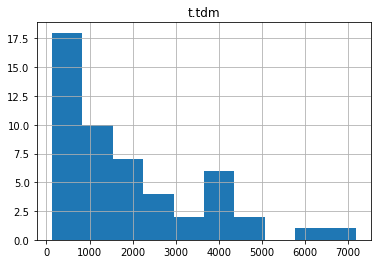

In [3]:
df[df["e.tdm"]==1][["t.tdm"]].hist()

### Choosing columns for training

In [4]:
removals = ['t.rfs', 'e.rfs', 't.os', 'e.os', 't.dmfs','e.dmfs', 't.tdm', 'e.tdm', "samplename", "id","filename","hospital", 'Surgery_type', 'Histtype', 'Angioinv', 'Lymp_infil', 'node', 'grade', 'er', 'risksg', 'risknpi', 'risk_AOL', 'veridex_risk']
rest = [i for i in df.columns if i not in removals]

In [5]:
X = df[rest]
y = df["t.tdm"]

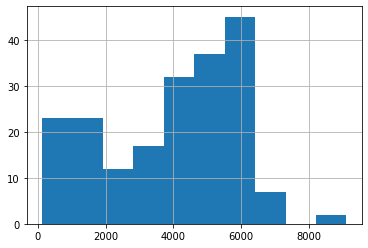

In [6]:
y.hist()

### Defining Indicator Functions

In [7]:
steps = 100
indicators = np.arange(0,10000,steps)

for indicator in indicators:
    df['indi_'+str(indicator)]= y < indicator
    

### Train-Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, df[['indi_'+str(indicator) for indicator in indicators]], test_size=0.33, random_state=42)
columns = y_train.columns

In [9]:
accs = []
for i,column in enumerate(columns):
    if( y_train[column].nunique()==1):
        y_test["prob_" + column] = 0
        y_test["survival_simple_" + column] = 1
        y_test["survival_log_" + column] = 0
        y_test["hazard_" + column] = 0
        continue
        
    clf = LogisticRegression(random_state=0,solver='liblinear')
    clf.fit(X_train, y_train[column])
    y_test["prob_" + column] = clf.predict_proba(X_test)[:,1]
    accs.append(clf.score(X_test, y_test[column]))
    if(i>1):
        y_test["prob_" + column] =  np.maximum(y_test["prob_" + columns[i-1]],y_test["prob_" + column])
        y_test["survival_simple_" + column] = 1 - y_test["prob_" + column]
        
        y_test["survival_log_" + column] = np.log(y_test["survival_simple_" + column])
        y_test["hazard_" + column] = ( - y_test["survival_log_" + columns[i]] + y_test["survival_log_" + columns[i-1]])/steps
print(np.mean(accs))

0.7455954897815363


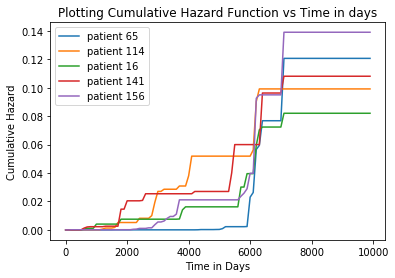

In [10]:
plt.figure()
for i in range(5):
    plt.plot(indicators, y_test.iloc[i,:][y_test.columns[y_test.columns.str.startswith("hazard_")]].cumsum(), label=f"patient {X_test.iloc[i].name}")
    
plt.xlabel('Time in Days')
plt.ylabel('Cumulative Hazard')
plt.xlabel('Time in Days')
plt.title("Plotting Cumulative Hazard Function vs Time in days")
plt.legend()

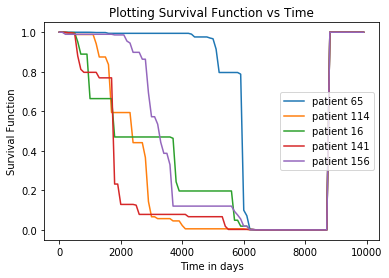

In [11]:
plt.figure()
for i in range(5):
    plt.plot(indicators, y_test.iloc[i,:][y_test.columns[y_test.columns.str.startswith("survival_simple_")]], label=f"patient {X_test.iloc[i].name}")
#plt.xlim([0,4000])
plt.xlabel("Time in days")
plt.ylabel("Survival Function")
plt.title("Plotting Survival Function vs Time")
plt.legend()

### Implementing Cobra

In [12]:
models = {"svc": svm.SVC, "knn": neighbors.KNeighborsClassifier, "dt": tree.DecisionTreeClassifier, "logreg": LogisticRegression, "gaussnb": GaussianNB, "lda": LinearDiscriminantAnalysis}

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, df[['indi_'+str(indicator) for indicator in indicators]], test_size=0.2, random_state=42)
columns = y_train.columns

In [77]:
y_train

,indi_0,indi_100,indi_200,indi_300,indi_400,indi_500,indi_600,indi_700,indi_800,indi_900,...,indi_9000,indi_9100,indi_9200,indi_9300,indi_9400,indi_9500,indi_9600,indi_9700,indi_9800,indi_9900
137,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
5,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
66,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
138,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
104,False,False,False,False,False,False,False,False,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
14,False,False,False,False,False,False,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
92,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
179,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


## Cobra Estimator Class

In [78]:
class NaiveCobra(BaseEstimator):
    """ Naive version of cobra which calculates aggregates for prediction."""
    def __init__(self, eps=None):
        ## Defining Parameters
        self.eps = eps
        self.machines = {}
        self.models = {'svc': svm.SVC,
                     'knn': neighbors.KNeighborsClassifier,
                     'dt': tree.DecisionTreeClassifier,
                     'logreg': LogisticRegression,
                     'gaussnb': GaussianNB,
                     'lda': LinearDiscriminantAnalysis}
        self.alpha = len(self.models)
    
    def fit(self, X_train, y_train):
        # Fitting each of the models
        for model_name in self.models:
            if model_name == "logreg":
                self.machines[model_name] = models[model_name](solver = 'liblinear').fit(X_train, y_train)
            elif model_name =='svc':
                self.machines[model_name] = models[model_name](probability = True).fit(X_train, y_train)
            else:
                self.machines[model_name] = models[model_name]().fit(X_train, y_train)
        
        return self
    def predict(self, X_test):
        # Genarating Predictions from trained regressors.
        self.machine_predictions_ = {}
        self.all_predictions_ = []
        for machine_name in self.machines:
            self.machine_predictions_[machine_name] = self.machines[machine_name].predict_proba(X_test)[:,1]
            self.all_predictions_.append(self.machine_predictions_[machine_name])
        self.all_predictions_= np.array(self.all_predictions_)
        selection_table = np.zeros((len(X_test), self.alpha))
        
        for machine_index, machine_name in enumerate(self.models.keys()):
            predicted_val = self.machines[machine_name].predict_proba(X_test)[:,1]

            for ind in range(0, len(X_test)):
                if fabs(self.machine_predictions_[machine_name][ind] - predicted_val[ind]) <= self.eps:
                    selection_table[ind][machine_index] = 1


        
        predicted_vals = []
        for ind in range(len(X_test)):
            if(np.sum(selection_table[ind]) == self.alpha):
                predicted_vals.append(np.mean(self.all_predictions_[:, ind]))
                
            else:
                predicted_vals.append(0)
        return np.array(predicted_vals)

In [79]:
X_train

,219340_s_at,217771_at,202418_at,206295_at,201091_s_at,204015_s_at,200726_at,200965_s_at,210314_x_at,221882_s_at,...,204218_at,221241_s_at,209862_s_at,217019_at,210593_at,216103_at,age,size,NPI,AOL_os_10y
137,7.144289,11.694656,10.227032,7.828162,10.287675,10.739937,11.980971,11.007295,9.762025,7.961261,...,9.031326,7.746159,8.005683,7.520753,6.589525,5.352141,37,2.4,4.48,67.9
5,7.767827,11.702955,10.862866,6.223989,9.853284,10.511941,11.548628,11.188773,9.696092,8.521187,...,9.260800,7.174011,8.711535,7.402978,4.177920,6.185510,58,2.0,3.40,83.1
66,6.754684,10.120764,10.396791,7.996839,9.579992,8.451258,11.921553,11.426899,10.480106,9.087801,...,10.090491,7.273899,8.339988,7.969904,7.030333,6.670013,50,1.3,2.26,92.4
138,6.576617,9.771298,11.028057,6.187405,9.892751,8.158213,11.741998,10.788644,9.988554,8.841236,...,8.537038,9.418794,8.238662,7.410974,6.013595,6.874884,42,2.5,4.50,67.3
104,6.629619,11.898642,10.386616,6.450043,11.635007,9.467840,11.641814,11.391989,9.146839,7.979607,...,9.538120,6.134391,8.772465,7.452738,5.875357,5.515670,43,2.0,3.40,89.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,7.082827,10.589015,9.958269,5.699627,10.052538,9.368311,11.940344,11.973381,10.661262,7.092396,...,8.590579,7.736641,9.016534,7.919161,4.074874,3.123401,43,0.8,2.16,96.5
14,7.409932,10.257966,11.534991,7.927440,10.931755,9.582779,11.323269,10.785040,10.074984,7.565632,...,10.306243,7.337673,10.062923,7.619398,5.556262,4.662503,33,2.5,4.50,68.1
92,6.959378,10.375818,11.007156,7.178920,10.427090,9.412671,11.392430,10.425997,9.170539,7.370092,...,9.451562,6.623424,8.173970,6.709534,6.071631,3.333941,54,1.0,4.20,85.7
179,6.245601,11.573055,10.794999,6.504507,10.435993,8.756178,11.561829,10.824587,9.007224,10.168902,...,9.009089,4.368726,8.717173,7.989804,6.877486,6.354594,42,2.5,4.50,74.2


In [110]:
class VenomCobra(BaseEstimator):
    """ Cobra implementation using voting mechanism."""
    def __init__(self, eps=None):
        ## Defining Parameters
        self.eps = eps
        self.machines = {}
        self.models = {'svc': svm.SVC,
                     'knn': neighbors.KNeighborsClassifier,
                     'dt': tree.DecisionTreeClassifier,
                     'logreg': LogisticRegression,
                     'gaussnb': GaussianNB,
                     'lda': LinearDiscriminantAnalysis}
        self.alpha = len(self.models)
        
    def __split_train_data(self, X, y, split_ratio):
        
        
        combined = pd.concat([X,y], axis =1)
        combined_0 = combined[combined.iloc[:,-1]==0]
        combined_1 = combined[combined.iloc[:,-1]==1]
        k_0 = int(split_ratio*len(combined_0))
        k_1 = int(split_ratio*len(combined_1))
        
        X_k = pd.concat([combined_0.iloc[:k_0,:-1], combined_1.iloc[:k_1,:-1]])
        y_k = pd.concat([combined_0.iloc[:k_0,-1], combined_1.iloc[:k_1,-1]])
        X_l = pd.concat([combined_0.iloc[k_0+1:,:-1], combined_1.iloc[k_1+1:,:-1]])
        y_l = pd.concat([combined_0.iloc[k_0+1:,-1], combined_1.iloc[k_1+1:,-1]])

        return X_k, y_k, X_l, y_l

    def fit(self, X, y):
        self.X = X
        self.y = y
        X_k, y_k, self.X_l, self.y_l = self.__split_train_data(self.X, self.y, 0.5)
        
        # Fitting each of the models
        for model_name in self.models:
            if model_name == "logreg":
                self.machines[model_name] = models[model_name](solver = 'liblinear').fit(X_k, y_k)
            elif model_name =='svc':
                self.machines[model_name] = models[model_name](probability = True).fit(X_k, y_k)
            else:
                self.machines[model_name] = models[model_name]().fit(X_k, y_k)
        self.generate_predictions()
        return self
    def generate_predictions(self):
        self.machine_predictions = {}
        self.all_predictions = np.array([])
        for machine_name in self.machines:
            self.machine_predictions[machine_name] = self.machines[machine_name].predict_proba(self.X_l)[:,1]
            self.all_predictions = np.append(self.all_predictions, self.machine_predictions[machine_name])
            
    def optimal_threshold(self, num_grid_points=10):

        if self.eps is None:
            a, size = sorted(self.all_predictions), len(self.all_predictions)
            res = [a[i + 1] - a[i] for i in range(size) if i+1 < size]
            emin = min(res)
            emax = max(a) - min(a)
            erange = np.linspace(emin, emax, num_grid_points)
            tuned_params = [{'eps': erange}]
            print("Grid Search Start")

            # GridSearchCV uses 5-fold cross validation by default.
            clf = GridSearchCV(self, tuned_params, scoring="neg_mean_squared_error", n_jobs=-1)
            clf.fit(self.X, self.y)
            
            self.eps = clf.best_params_["eps"]  
            print("Grid Search Complete, eps: ", self.eps)
            
    def predict(self, X_test):
        # Genarating Predictions from trained regressors.
        preds = []
        for x in X_test.values:
            x = np.array(x)
            x = x.reshape(1, -1)
            selection_table = np.zeros((len(self.X_l), self.alpha))
        
            for machine_index, machine_name in enumerate(self.models.keys()):
                predicted_val = self.machines[machine_name].predict_proba(x)[:,1]

                for ind in range(0, len(self.X_l)):
                    if fabs(self.machine_predictions[machine_name][ind] - predicted_val) <= self.eps:
                        selection_table[ind][machine_index] = 1


            selected_indices = []
            

            for ind in range(len(self.X_l)):
                if(np.sum(selection_table[ind]) == self.alpha):
                    selected_indices.append(ind)

            pred = 0
            for ind in selected_indices:
                pred+=self.y_l.iloc[ind]
            if (len(selected_indices)!=0):
                pred/=len(selected_indices)
            preds.append(pred)
        return np.array(preds)

In [111]:
accs = []
for i,column in enumerate(columns):
    
    if( y_train[column].nunique()==1 or y_train[column].value_counts()[0] ==1 or y_train[column].value_counts()[1] ==1):
        y_test["prob_" + column] = 0
        y_test["survival_simple_" + column] = 1
        y_test["survival_log_" + column] = 0
        y_test["hazard_" + column] = 0
        continue

    cobra = VenomCobra(eps = 0.95)
    cobra = cobra.fit(X_train, y_train[column])
#     cobra.optimal_threshold()
    preds = cobra.predict(X_test)
    y_test["prob_" + column] = preds
    preds[preds > 0.5] = 1
    preds[preds <= 0.5] = 0
    accs.append(accuracy_score(preds, y_test[column]))
    if(i>1):
        y_test["prob_" + column] =  np.maximum(y_test["prob_" + columns[i-1]],y_test["prob_" + column])
        y_test["survival_simple_" + column] = 1 - y_test["prob_" + column]
        
        y_test["survival_log_" + column] = np.log(y_test["survival_simple_" + column])
        y_test["hazard_" + column] = ( - y_test["survival_log_" + columns[i]] + y_test["survival_log_" + columns[i-1]])/steps
print(np.mean(accs))

0.7838235294117647


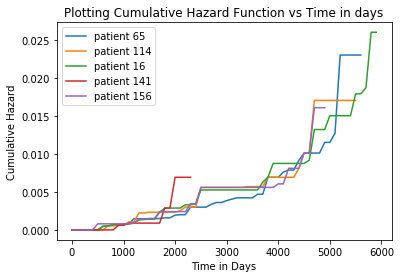

In [112]:
plt.figure()
for i in range(5):
    plt.plot(indicators, y_test.iloc[i,:][y_test.columns[y_test.columns.str.startswith("hazard_")]].cumsum(), label=f"patient {X_test.iloc[i].name}")
    
plt.xlabel('Time in Days')
plt.ylabel('Cumulative Hazard')
plt.xlabel('Time in Days')
plt.title("Plotting Cumulative Hazard Function vs Time in days")
plt.legend()

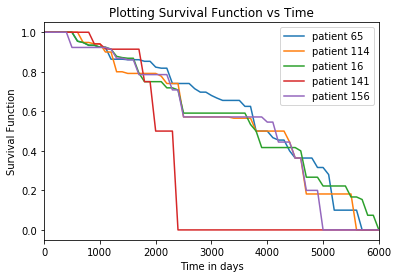

In [113]:
plt.figure()
for i in range(5):
    plt.plot(indicators, y_test.iloc[i,:][y_test.columns[y_test.columns.str.startswith("survival_simple_")]], label=f"patient {X_test.iloc[i].name}")
plt.xlim([0,6000])
plt.xlabel("Time in days")
plt.ylabel("Survival Function")
plt.title("Plotting Survival Function vs Time")
plt.legend()